In [1]:
import os, sys
import cv2
import numpy as np
import uuid
import tensorflow as tf
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from imutils import paths
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from core.imageprep import random_crop, crop_generator, random_crop_batch
from core.models import UNet

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

 ## Load Training Dataset

In [2]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')
imgdir = os.path.join('training', 'cell_membrane', 'prepdata')
imgpath = os.path.join(path, imgdir)

Load Images...


## specify parameter

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

## Predict from Testing Dataset

In [4]:
testpath = os.path.join(imgpath, 'test', 'images')
print(testpath)

testpath_all = list(paths.list_images(os.path.join(testpath, 'cell_membrane')))
print(testpath_all[0])

D:PerlmutterData\training\cell_membrane\prepdata\test\images
D:PerlmutterData\training\cell_membrane\prepdata\test\images\cell_membrane\DestrWL0000.tif


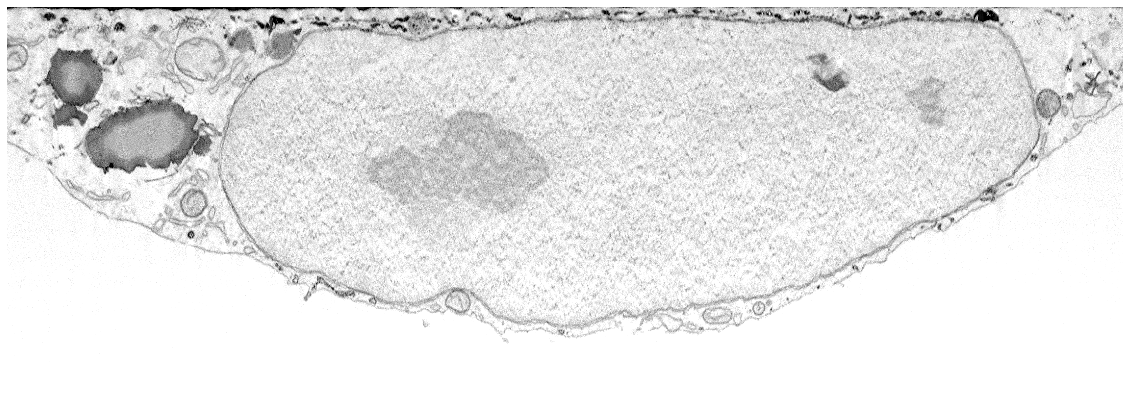

In [5]:
img = imread(testpath_all[0])
plt.figure(figsize = (20,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [104]:
modelpath = os.path.join(path, 'model', 'model_2019_11_12_14_33.h5')
print(modelpath)

D:PerlmutterData\model\model_2019_11_12_14_33.h5


In [105]:
from tensorflow.keras.models import load_model
model=load_model(modelpath)
print(model)

In [8]:
img.shape

(794, 2286)

In [9]:
data_gen_args = dict(
                # featurewise_center=True,
                # featurewise_std_normalization=True,
                # horizontal_flip=True,
                # vertical_flip=True,
                # rotation_range=90.,
                # width_shift_range=0.1,
                # height_shift_range=0.1,
                # shear_range=0.07,
                # zoom_range=0.2,
                # validation_split=validation_split, # <- specify validation_split ratio
                # fill_mode='constant',
                # cval=0.,
                # rescale=1.0/255.0,
                )

In [10]:
image_datagen = ImageDataGenerator(**data_gen_args)

In [11]:
predict_image_generator = image_datagen.flow_from_directory(
    testpath,
    target_size = (IMG_HEIGHT, IMG_WIDTH), 
    color_mode='grayscale',
    batch_size = 16,
    class_mode = None, 
    shuffle = False
    )

Found 5 images belonging to 1 classes.


In [12]:
img_predict = model.predict_generator(predict_image_generator, verbose = 1)

1/1 [==============================] - 3s 3s/step


In [13]:
img_predict.shape

(5, 256, 256, 1)

In [14]:
img_predict_1 = img_predict[0].reshape((256, 256))
img_predict_1.shape

(256, 256)

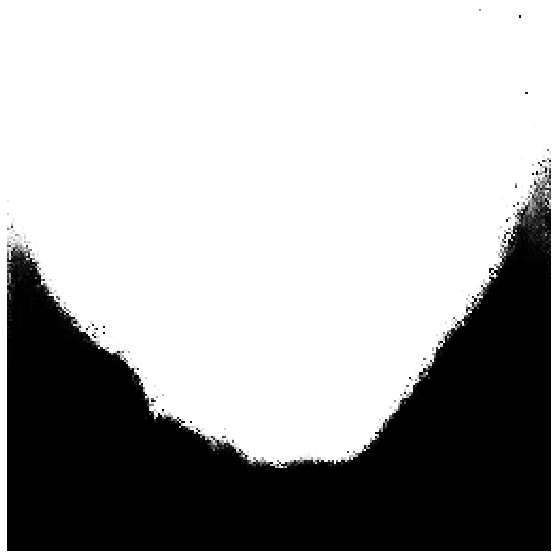

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(img_predict_1, cmap='gray')
plt.axis('off')
plt.show()

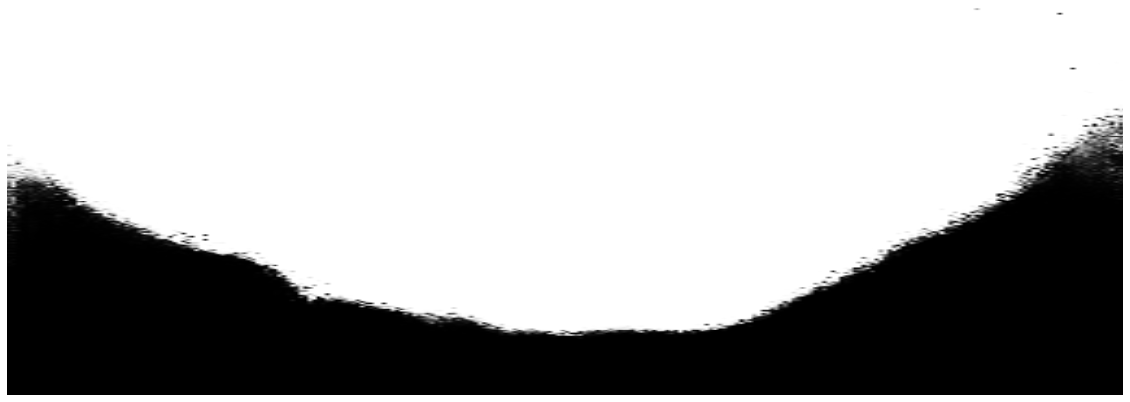

In [16]:
from skimage.transform import resize
img_predict_resize = resize(img_predict_1, (img.shape[0], img.shape[1]))
plt.figure(figsize = (20,20))
plt.imshow(img_predict_resize, cmap='gray')
plt.axis('off')
plt.show()

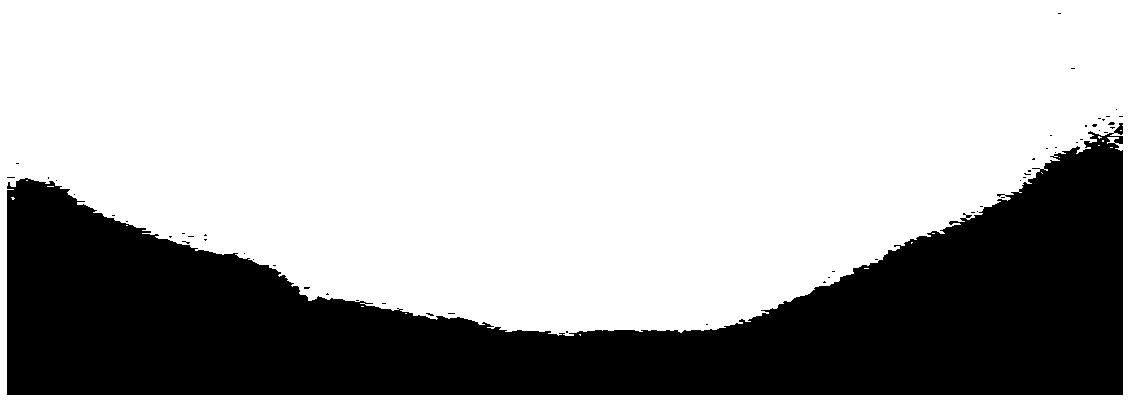

In [17]:
img_predict_th = img_predict_resize > 0.5
plt.figure(figsize = (20,20))
plt.imshow(img_predict_th, cmap='gray')
plt.axis('off')
plt.show()

## Tiling Prediction
- Crop image into patched by a given overlap factor
- Export a cropping index
- Construct patches back into a image 

In [64]:
from core.imageprep import create_crop_idx, crop_to_patch
IMG_HEIGHT = 256
IMG_WIDTH = 256

cropidx = create_crop_idx(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)


Image Shape: 794, 2286
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 78
Step x: 230
Step x count: 10
Remainder in x: 190


In [65]:
print(cropidx)

[[   0  256    0  256    0    0]
 [   0  256  230  486    0    1]
 [   0  256  460  716    0    2]
 [   0  256  690  946    0    3]
 [   0  256  920 1176    0    4]
 [   0  256 1150 1406    0    5]
 [   0  256 1380 1636    0    6]
 [   0  256 1610 1866    0    7]
 [   0  256 1840 2096    0    8]
 [   0  256 2030 2286    0    9]
 [ 230  486    0  256    1    0]
 [ 230  486  230  486    1    1]
 [ 230  486  460  716    1    2]
 [ 230  486  690  946    1    3]
 [ 230  486  920 1176    1    4]
 [ 230  486 1150 1406    1    5]
 [ 230  486 1380 1636    1    6]
 [ 230  486 1610 1866    1    7]
 [ 230  486 1840 2096    1    8]
 [ 230  486 2030 2286    1    9]
 [ 460  716    0  256    2    0]
 [ 460  716  230  486    2    1]
 [ 460  716  460  716    2    2]
 [ 460  716  690  946    2    3]
 [ 460  716  920 1176    2    4]
 [ 460  716 1150 1406    2    5]
 [ 460  716 1380 1636    2    6]
 [ 460  716 1610 1866    2    7]
 [ 460  716 1840 2096    2    8]
 [ 460  716 2030 2286    2    9]
 [ 538  79

In [33]:
outputimg = crop_to_patch(img, cropidx, (IMG_HEIGHT, IMG_WIDTH))

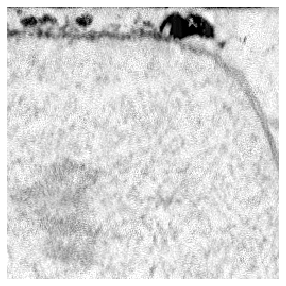

In [34]:
plt.figure(figsize = (5,5))
plt.imshow(outputimg[36], cmap='gray')
plt.axis('off')
plt.show()

In [35]:
outputimg_re = np.reshape(outputimg, (outputimg.shape[0], outputimg.shape[1], outputimg.shape[2], 1))
outputimg_re.shape

(492, 256, 256, 1)

In [38]:
img_pre_stack = model.predict(outputimg_re, batch_size = 16, verbose = 1)

492/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

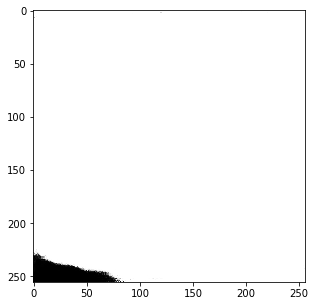

In [45]:
plt.figure(figsize = (5,5))
plt.imshow(np.reshape(img_pre_stack[300], (256, 256)), cmap='gray')
plt.axis('on')
plt.show()

In [40]:
from core.imageprep import construct_from_patch
outputimg = construct_from_patch(img_pre_stack, cropidx, target_size = (img.shape[0], img.shape[1]))


Patch Image Shape: 256, 256
Target Image Size: 794, 2286


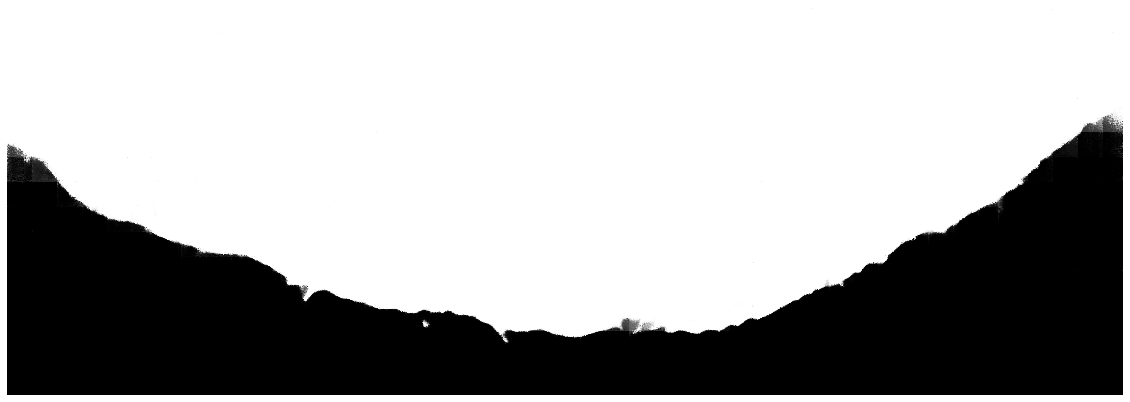

In [41]:
plt.figure(figsize = (20,20))
plt.imshow(outputimg, cmap='gray')
plt.axis('on')
plt.show()

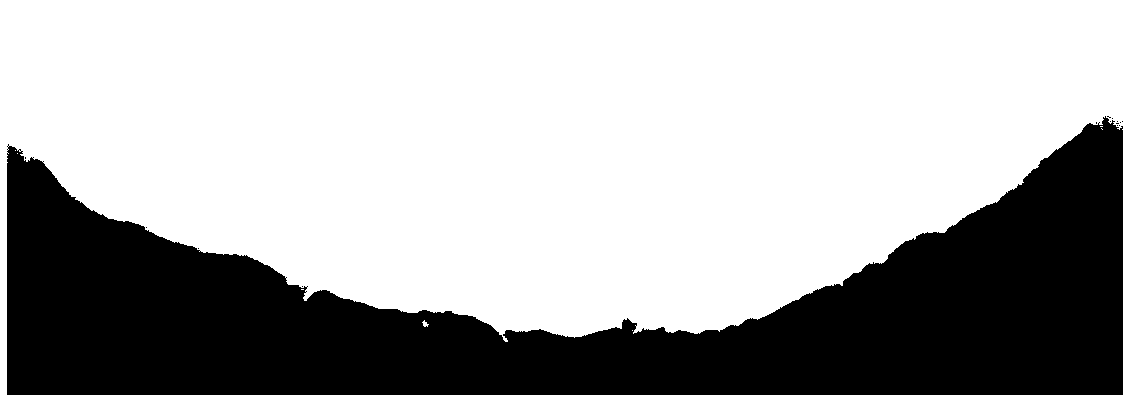

In [42]:
outputimg_T = outputimg > 0.5
plt.figure(figsize = (20,20))
plt.imshow(outputimg_T, cmap='gray')
plt.axis('off')
plt.show()

## Apply to a stack

In [96]:
from core.imageprep import create_crop_idx, crop_to_patch, construct_from_patch
from core.train_predict import stack_predict
from tqdm.notebook import trange

test_input_path = os.path.join(imgpath, 'test', 'images')
inputtestpath_all = list(paths.list_images(os.path.join(test_input_path, 'cell_membrane')))
print(inputtestpath_all)

if not 'labels' in os.listdir(os.path.join(imgpath, 'test')):
    os.mkdir(os.path.join(imgpath, 'test', 'labels'))
    os.mkdir(os.path.join(imgpath, 'test', 'labels', 'cell_membrane'))
test_output_path = os.path.join(imgpath, 'test', 'labels', 'cell_membrane')

['D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0000.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0001.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0002.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0003.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0004.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0005.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0006.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0007.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL0008.tif', 'D:PerlmutterData\\training\\cell_membrane\\prepdata\\test\\images\\cell_membrane\\DestrWL

[autoreload of core.train_predict failed: Traceback (most recent call last):
  File "C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\wucci_admin\Documents\code\dl_fibem_seg\core\train_predict.py", line 10, in <module>
    from core.train_predict im

In [99]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

img_tmp = imread(testpath_all[0])
cropidx = create_crop_idx(img_tmp.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)


Image Shape: 794, 2286
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 78
Step x: 230
Step x count: 10
Remainder in x: 190


In [113]:
from core.train_predict import stack_predict

stack_predict(input_imgpath = inputtestpath_all, 
              output_imgpath = test_output_path, 
              cropidx = cropidx, 
              model = model, 
              patch_size = (IMG_HEIGHT, IMG_WIDTH), 
              predict_threshold = 0.5)



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 794, 2286

